# How to create a session object, and work with it

In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# import modules from 2p-py
import labrotation.file_handling as file_handling
import labrotation.two_photon_session as two_photon_session
import labrotation.belt_processing as belt_processing

## Set matlab-2p path
matlab is unfortunately still needed, as the belt processing scripts were written in Matlab and have not yet been implemented in Python. See the Test Matlab Integration jupyter notebook on how to set up Matlab in Python.

In [3]:
matlab_2p_path = file_handling.open_dir("Choose matlab-2p folder!")

## Set file path variables

In [4]:
nd2_path = file_handling.open_file("Choose Nikon imaging file (.nd2)!")
nd2_meta_path = file_handling.open_file("Choose Nikon metadata file (.txt)!")
labview_path = file_handling.open_file("Choose LabView file (xy.txt, NOT xytime.txt)!")
labview_timestamps_path = labview_path[:-4] + "time.txt"
lfp_path = file_handling.open_file("Choose LFP file (.abf)!")

## Create session object
Functions such as matching the belt with the nikon recording will be automatically run.

In [8]:
session = two_photon_session.TwoPhotonSession(nd2_path, nd2_meta_path, labview_path, labview_timestamps_path, lfp_path, matlab_2p_path)

D:\Software\Anaconda\envs\py9\lib\site-packages\pims\base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


Difference of starting times (s): 23.644011


## session is ready to work with!
Check class documentation (or source code) for functionalities

In [13]:
movement_t, movement_y = session.lfp_movement()
lfp_t, lfp_y = session.lfp_lfp()

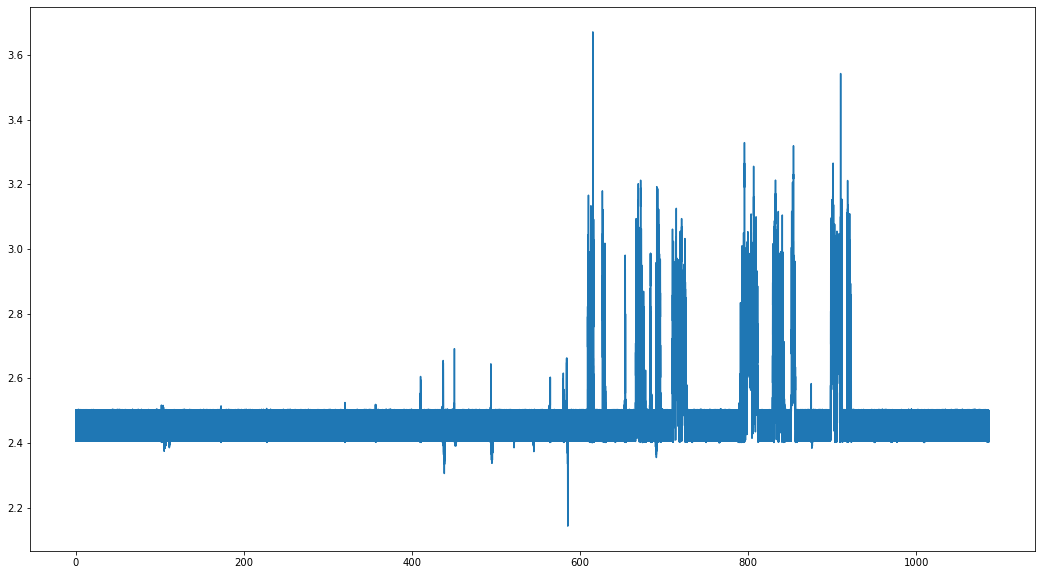

In [19]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18,10))
plt.plot(movement_t, movement_y)
plt.show()

## Close session (before opening a new one, for example)

In [6]:
session.dirty_close()  # this does NOT de-reference session! Just sets the data fields to None so it can be re-used. This should be fixed soon.

In [7]:
session